# 단어 임베딩
## Embedding 층을 사용해 단어 임베딩 학습하기
* 단어 벡터 사이에 조금 더 추상적이고 기하학적인 관계를 얻기 위해 단어 사이에 있는 의미 관계를 반영하기 
    * 언어를 기하학적 공간에 매핑하기 
    * 잘 구축된 임베딩 공간에서는 동의어가 비슷한 단어 벡터로 임베딩될 것.. 
    * 일반적으로 두 단어 벡터 사이의 거리(L2 거리)는 이 단어 사이의 의미 거리와 관계(서로 의미가 다른 단어는 멀리 떨어진 위치에, 비슷한 단어들은 가까이)

### ```Embedding```
* 크기가 (samples, sequence_length)인 2D 정수 텐서를 입력받음
* 크기가 (samples, sequence_length, embedding_dimensionality)인 3D 실수형 텐서를 반환

### Embedding 층의 객체 생성하기

In [23]:
from keras.layers import Embedding

# 가능한 토큰의 개수(1,000: 단어 인덱스 최댓값 + 1), 임베딩 차원(64)
embedding_layer = Embedding(1000, 64)

### Embedding층에 사용할 IMDB 데이터 로드

In [24]:
from keras.datasets import imdb
from keras import preprocessing

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 자주 사용되는 max_features 개의 단어만 사용)
maxlen = 20

# 정수 리스트로 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 리스트를 (samples, maxlen) 크기의 2D 정수 텐서로 변환
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### IMDB 데이터에 Embedding층과 분류기 사용하기

In [25]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
# 나중에 임베딩된 입력을 Flatten 층에서 펼치기 위해 Embedding 층에 input_length를 지정
model.add(Embedding(10000, 8, input_length=maxlen))
# Embedding 층의 출력 크기는 (samples, maxlen, 8)가 된다!

# 3D 임베딩 텐서를 (samples, maxlen * 8) 크기의 2D 텐서로 펼치기
model.add(Flatten())

# 분류기 추가
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_5 (Flatten)         (None, 160)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
  5/625 [..............................] - ETA: 8s - loss: 0.6947 - acc: 0.4688  

2022-03-28 21:22:13.378878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 0.6660 - acc: 0.6248

2022-03-28 21:22:19.539195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 7s 10ms/step - loss: 0.6658 - acc: 0.6253 - val_loss: 0.6114 - val_acc: 0.6960
Epoch 2/10
625/625 [==============================] - 6s 10ms/step - loss: 0.5362 - acc: 0.7524 - val_loss: 0.5221 - val_acc: 0.7316
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4599 - acc: 0.7887 - val_loss: 0.5017 - val_acc: 0.7444
Epoch 4/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4246 - acc: 0.8064 - val_loss: 0.4934 - val_acc: 0.7536
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.4006 - acc: 0.8201 - val_loss: 0.4955 - val_acc: 0.7544
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3809 - acc: 0.8288 - val_loss: 0.4991 - val_acc: 0.7532
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.3629 - acc: 0.8399 - val_loss: 0.5018 - val_acc: 0.7534
Epoch 8/10
625/625 [==============================] - 6s 10ms/step - loss: 0.345

In [26]:
import numpy as np
print(np.mean(history.history['val_acc']))

0.7453200399875641


---
## 사전 훈련된 단어 임베딩 사용하기

> 풀려는 문제와 함께 단어 임베딩을 학습하는 대신에 미리 계산된 임베딩 공간에서 임베딩 벡터를 로드하기 
* 뛰어난 구조와 유용한 성질을 가진 임베딩 공간 -> 언어 구조의 일반적인 측면을 잡아낼 수 있음! 
* 자연어 처리에서 사전 훈련된 단어 임베딩을 사용하는 이유?: 충분한 데이터가 없어서 자신만의 좋은 특성을 학습하지 못하지만 꽤 일반적인 특성이 필요할 때..

### 토큰화 되지 않은 IMDB 원본 데이터 받기

In [40]:
import os

imdb_dir = '../datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### 데이터 토큰화

In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버리기
training_samples = 200  # 훈련 샘플: 200개
validation_samples = 10000  # 검증 샘플: 10,000개
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플 나옴) 먼저 데이터를 섞기
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


### GloVe 단어 임베딩 전처리
.txt파일을 파싱하여 단어에 상응하는 벡터 표현을 매핑하는 인덱스 만들기

In [29]:
glove_dir = '../datasets/glove-6b'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


```Embedding``` 층에 주입할 수 있도록 임베딩 행렬을 만들기  
* 행렬의 크기: (max_words, embedding_dim)  
* 행렬의 i번째 원소: (토큰화로 만든) 단어 인덱스의 i번째 단어에 상응하는 embedding_dim 차원 벡터  
* 인덱스 0: 어떤 단어나 토큰도 아닐 경우

In [30]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0으로
            embedding_matrix[i] = embedding_vector

### 모델 정의

In [1]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

ModuleNotFoundError: No module named 'keras'

### 모델에 GloVe 임베딩 로드하기
Embedding 층은 하나의 가중치 2D 부동 소수 행렬을 가진다  
각 i번째 원소는 i번째 인덱스에 상응하는 단어 벡터  
모델의 첫 번째 층인 Embedding 층에 준비된 GloVe 행렬을 로드:  
* 추가적으로 Embedding 층을 동결(이미 학습된 특성 오염 방지)

In [32]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### 모델 훈련과 평가

In [33]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
1/7 [===>..........................] - ETA: 2s - loss: 0.6281 - acc: 0.6250

2022-03-28 21:24:11.973954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 1.9422 - acc: 0.5750

2022-03-28 21:24:12.251903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 185ms/step - loss: 1.9422 - acc: 0.5750 - val_loss: 1.4673 - val_acc: 0.5007
Epoch 2/10
7/7 [==============================] - 1s 169ms/step - loss: 0.6765 - acc: 0.6600 - val_loss: 1.1318 - val_acc: 0.5009
Epoch 3/10
7/7 [==============================] - 1s 155ms/step - loss: 0.5494 - acc: 0.7000 - val_loss: 1.0965 - val_acc: 0.5005
Epoch 4/10
7/7 [==============================] - 1s 159ms/step - loss: 0.3518 - acc: 0.8350 - val_loss: 1.6228 - val_acc: 0.5006
Epoch 5/10
7/7 [==============================] - 1s 158ms/step - loss: 0.3196 - acc: 0.8950 - val_loss: 1.3298 - val_acc: 0.4993
Epoch 6/10
7/7 [==============================] - 1s 155ms/step - loss: 0.2189 - acc: 0.9350 - val_loss: 0.8681 - val_acc: 0.5241
Epoch 7/10
7/7 [==============================] - 1s 154ms/step - loss: 0.1327 - acc: 0.9850 - val_loss: 2.0781 - val_acc: 0.5001
Epoch 8/10
7/7 [==============================] - 1s 156ms/step - loss: 0.2243 - acc: 0.9100 - val_lo

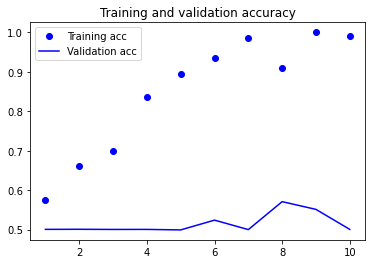

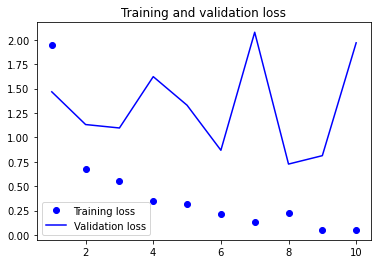

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 모델은 과대적합이 빠르게 시작된다.. (훈련 샘플 수가 작기 때문)

### 사전훈련된 단어 임베딩 없이 같은 모델 훈련하기

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_7 (Flatten)         (None, 10000)             0         
                                                                 
 dense_12 (Dense)            (None, 32)                320032    
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/7 [===>..........................] - ETA: 2s - loss: 0.6850 - acc: 0.6875

2022-03-28 21:24:30.067026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.6901 - acc: 0.5650

2022-03-28 21:24:30.457527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 198ms/step - loss: 0.6901 - acc: 0.5650 - val_loss: 0.6948 - val_acc: 0.4967
Epoch 2/10
7/7 [==============================] - 1s 172ms/step - loss: 0.4475 - acc: 0.9900 - val_loss: 0.7107 - val_acc: 0.5030
Epoch 3/10
7/7 [==============================] - 1s 167ms/step - loss: 0.2392 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.5230
Epoch 4/10
7/7 [==============================] - 1s 167ms/step - loss: 0.1092 - acc: 1.0000 - val_loss: 0.7406 - val_acc: 0.5061
Epoch 5/10
7/7 [==============================] - 1s 172ms/step - loss: 0.0514 - acc: 1.0000 - val_loss: 0.7190 - val_acc: 0.5193
Epoch 6/10
7/7 [==============================] - 1s 169ms/step - loss: 0.0272 - acc: 1.0000 - val_loss: 0.7633 - val_acc: 0.5062
Epoch 7/10
7/7 [==============================] - 1s 167ms/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.7310 - val_acc: 0.5221
Epoch 8/10
7/7 [==============================] - 1s 181ms/step - loss: 0.0091 - acc: 1.0000 - val_lo

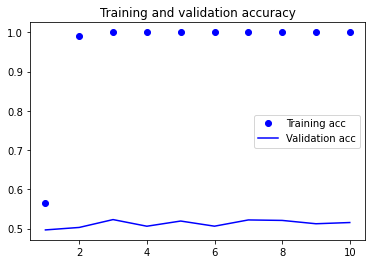

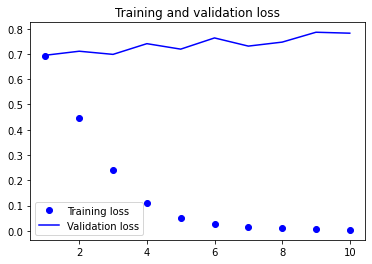

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

훈련 샘플 수가 적어서 검증 정확도 50% 초반에 머물고있다ㅠㅠ

### 테스트 데이터에서 모델 평가하기
테스트 데이터 토큰화

In [37]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

모델 로드 후 평가하기

In [38]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 1.9558 - acc: 0.5008


[1.9557899236679077, 0.5008000135421753]

50.0%의 테스트 정확도 달성..

---
## 훈련 샘플 수 늘려보기
훈련 샘플 수를 2000개로 증가해서 학습시켜보자..

In [41]:
# 훈련 데이터 2000개로 데이터 토큰화
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버리기
training_samples = 2000  # 훈련 샘플: 2000개로 증가!
validation_samples = 10000  # 검증 샘플: 10,000개
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플 나옴) 먼저 데이터를 섞기
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [42]:
# 사전 훈련된 단어 임베딩 버전
model1 = Sequential()
model1.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False

model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history1 = model1.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_14 (Dense)            (None, 32)                320032    
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 1/63 [..............................] - ETA: 19s - loss: 0.7123 - acc: 0.5938

2022-03-28 21:26:00.280826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.8410 - acc: 0.5535

2022-03-28 21:26:00.928833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 23ms/step - loss: 0.8410 - acc: 0.5535 - val_loss: 0.6944 - val_acc: 0.4966
Epoch 2/10
63/63 [==============================] - 1s 20ms/step - loss: 0.6700 - acc: 0.6440 - val_loss: 0.8124 - val_acc: 0.4971
Epoch 3/10
63/63 [==============================] - 1s 20ms/step - loss: 0.5671 - acc: 0.7225 - val_loss: 0.6499 - val_acc: 0.6314
Epoch 4/10
63/63 [==============================] - 1s 20ms/step - loss: 0.4363 - acc: 0.8070 - val_loss: 0.9288 - val_acc: 0.5472
Epoch 5/10
63/63 [==============================] - 1s 20ms/step - loss: 0.3422 - acc: 0.8465 - val_loss: 0.7050 - val_acc: 0.6307
Epoch 6/10
63/63 [==============================] - 1s 20ms/step - loss: 0.2977 - acc: 0.8745 - val_loss: 0.7887 - val_acc: 0.6010
Epoch 7/10
63/63 [==============================] - 1s 20ms/step - loss: 0.2160 - acc: 0.9190 - val_loss: 0.7507 - val_acc: 0.6346
Epoch 8/10
63/63 [==============================] - 1s 20ms/step - loss: 0.1632 - acc: 0.9500 

In [43]:
model1.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.8249 - acc: 0.6446


[0.8248974680900574, 0.6446000337600708]

사전 훈련된 임베딩 사용 결과: 정확도 64.5%로 증가

In [44]:
# 사전 훈련된 단어 임베딩 사용하지 않기!
# 입력 토큰 학습하도록..
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 flatten_9 (Flatten)         (None, 10000)             0         
                                                                 
 dense_16 (Dense)            (None, 32)                320032    
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 1/63 [..............................] - ETA: 22s - loss: 0.6970 - acc: 0.4062

2022-03-28 21:26:41.785100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.6877 - acc: 0.5420

2022-03-28 21:26:43.107855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 34ms/step - loss: 0.6877 - acc: 0.5420 - val_loss: 0.6745 - val_acc: 0.5918
Epoch 2/10
63/63 [==============================] - 2s 31ms/step - loss: 0.3237 - acc: 0.9535 - val_loss: 0.6014 - val_acc: 0.6726
Epoch 3/10
63/63 [==============================] - 2s 31ms/step - loss: 0.0422 - acc: 0.9970 - val_loss: 0.5726 - val_acc: 0.7147
Epoch 4/10
63/63 [==============================] - 2s 28ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.6014 - val_acc: 0.7251
Epoch 5/10
63/63 [==============================] - 2s 28ms/step - loss: 2.4836e-04 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.7331
Epoch 6/10
63/63 [==============================] - 2s 28ms/step - loss: 1.3031e-05 - acc: 1.0000 - val_loss: 0.7307 - val_acc: 0.7357
Epoch 7/10
63/63 [==============================] - 2s 29ms/step - loss: 1.1047e-06 - acc: 1.0000 - val_loss: 0.8011 - val_acc: 0.7360
Epoch 8/10
63/63 [==============================] - 2s 28ms/step - loss: 2.3107e-0

In [45]:
model2.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.9085 - acc: 0.7367


[0.9084743857383728, 0.7366800308227539]

입력 토큰 직접 학습하도록한 결과: 73.7% 정확도 달성!

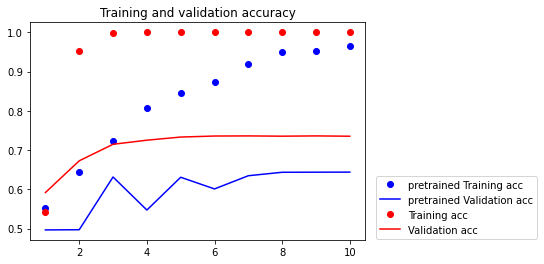

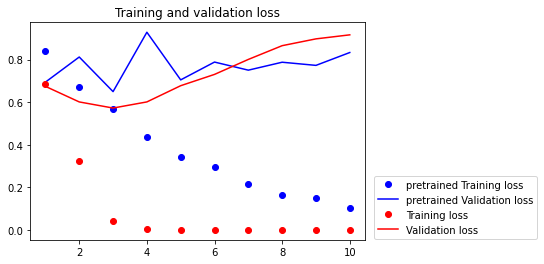

In [46]:
import matplotlib.pyplot as plt

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc1, 'bo', label='pretrained Training acc')
plt.plot(epochs, val_acc1, 'b', label='pretrained Validation acc')
plt.plot(epochs, acc2, 'ro', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend( ncol=1, loc='center right', bbox_to_anchor=(1.53,0.15), scatterpoints=1)

plt.figure()

plt.plot(epochs, loss1, 'bo', label='pretrained Training loss')
plt.plot(epochs, val_loss1, 'b', label='pretrained Validation loss')
plt.plot(epochs, loss2, 'ro', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend( ncol=1, loc='center right', bbox_to_anchor=(1.53,0.15), scatterpoints=1)

plt.show()